# IMU Data Classification

In [23]:
# Visualisation
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import dataframe_image as dfi
import warnings

# Data processing
from sklearn.impute import KNNImputer

# Machine learning
from sklearn.model_selection import train_test_split

# Helper functions
from helper.helper_filter import *
from helper.helper_preprocess import *
from helper.helper_train import *

## Filter data
### Extract data tables and visualise

In [38]:
# Read the raw data from each target action and store them in a list
lqw_raw = load_data("./IMU_Data/LGW")
ramp_ascend_raw = load_data("./IMU_Data/Ramp_ascend")
ramp_descend_raw = load_data("./IMU_Data/Ramp_descend")
sit_to_stand_raw = load_data("./IMU_Data/Sit_to_stand")
stand_to_sit_raw = load_data("./IMU_Data/Stand_to_sit")

folders = [lqw_raw, ramp_ascend_raw, ramp_descend_raw, sit_to_stand_raw, stand_to_sit_raw]

In [39]:
# Preview some of the data to check format
lqw_raw[0].data.describe()

,Thigh_R_Timestamp,Thigh_R_Gyroscope_X,Thigh_R_Gyroscope_Y,Thigh_R_Gyroscope_Z,Thigh_R_Accelerometer_X,Thigh_R_Accelerometer_Y,Thigh_R_Accelerometer_Z,Thigh_R_Magnetometer_X,Thigh_R_Magnetometer_Y,Thigh_R_Magnetometer_Z,...,Pelvis_Gyroscope_Y,Pelvis_Gyroscope_Z,Pelvis_Accelerometer_X,Pelvis_Accelerometer_Y,Pelvis_Accelerometer_Z,Pelvis_Magnetometer_X,Pelvis_Magnetometer_Y,Pelvis_Magnetometer_Z,Annotation_Pulse,Annotation_Level
count,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,...,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.0,1626.0
mean,249721.679675,3.016005,-20.459045,2.968838,-1.211503,9.496468,3.547880,-0.098999,-0.685384,-0.268764,...,-21.807592,-5.205306,-0.005444,9.747295,-0.915822,-0.016177,-0.644223,0.072678,0.0,0.0
std,4585.254729,37.556036,99.867926,77.125395,4.501860,2.824768,2.773884,0.350785,0.133166,0.212483,...,52.899000,20.501709,1.588494,1.822342,1.491137,0.288767,0.080635,0.278026,0.0,0.0
min,241787.109400,-119.396500,-443.269200,-193.665800,-19.053100,0.554900,-10.541900,-0.706700,-1.003900,-0.696300,...,-229.559600,-66.004400,-5.997400,5.480000,-7.538100,-0.482400,-0.833300,-0.320300,0.0,0.0
25%,245754.394500,-18.716200,-85.597100,-31.442400,-3.091850,8.115800,2.167850,-0.384800,-0.763100,-0.449000,...,-26.214600,-17.276975,-1.092800,8.343075,-1.701800,-0.275950,-0.703100,-0.177400,0.0,0.0
50%,249721.679700,-0.304400,1.286950,20.257900,-1.640950,9.261300,3.509750,-0.142900,-0.681600,-0.232100,...,-5.902800,-2.967900,-0.039300,9.638200,-0.943300,-0.152100,-0.639800,-0.110600,0.0,0.0
75%,253688.964800,23.651300,43.328700,63.823900,0.294725,10.788800,4.824850,0.186225,-0.605800,-0.123600,...,7.363425,9.336600,1.070175,10.804825,0.149500,0.278300,-0.592000,0.331800,0.0,0.0
max,257656.250000,124.481600,296.799300,107.897900,22.233200,21.557300,17.202800,0.628600,-0.355300,0.305900,...,63.326800,39.415100,4.163400,15.563400,3.690000,0.413700,-0.413800,0.656700,0.0,0.0


In [40]:
lqw_raw[0].data.head()
dfi.export(lqw_raw[0].data, "assets/table_1.png", max_rows=10, max_cols=6)

In [41]:
# Plot histograms to visualize all data
#lqw_raw[0].data.hist(bins=50,figsize=(30,30))

In [42]:
# Check entries that are outside of the standard deviation
std_table = []
head = ["Action","File name", "Column name", "Mean", "Standard deviation", "#entries>5std", "#entries<5std"]

for folder in folders:
    for file in folder:
        for column in file.data:
            mean = file.data[column].mean()
            std = file.data[column].std()
            count_above_std5 = 0
            count_below_std5 = 0

            for entry in file.data[column]:
                if entry < mean - std*5:
                    count_below_std5 += 1
                elif entry > mean + std*5:
                    count_above_std5 += 1

            if count_above_std5 > 0 or count_below_std5 > 0:
                std_table.append([file.folder_name, file.file_name, column, format(mean, '.4f'), format(std, '.4f'), count_above_std5, count_below_std5]) # add data for every column

print(tabulate(std_table, headers=head, tablefmt="grid"))

+--------------+---------------------------------------+-------------------------+----------+----------------------+-----------------+-----------------+
| Action       | File name                             | Column name             |     Mean |   Standard deviation |   #entries>5std |   #entries<5std |
+==============+=======================================+=========================+==========+======================+=================+=================+
| LGW          | normal_walk_J_trial_02.dat            | Thigh_R_Accelerometer_X |  -1.2115 |               4.5019 |               1 |               0 |
+--------------+---------------------------------------+-------------------------+----------+----------------------+-----------------+-----------------+
| LGW          | normal_walk_J_trial_02.dat            | Thigh_R_Accelerometer_Z |   3.5479 |               2.7739 |               0 |               1 |
+--------------+---------------------------------------+-------------------------+

### Check for unwanted columns
From the table above, we can see how multiple timestamps have been used across different files. It was decided to investigate further whether the timestamps are aligned and can be ignored. It can be seen how, under the LGW some files are missing "Sync" and "Offset" timestamp files, so it was decided to remove all columns that contains them to ensure consistency across the data. Additionally, the LWR from SV is missing the timestamp from the Right sensors and Thigh. The timestamps that appear across al columns are 'Shank_L_Timestamp', 'Foot_L_Timestamp', 'Pelvis_Timestamp', arguebly one of them should be used as the baseline time.

The total number of entries is plotted as well, it can be seen how the majority of the data comes from the ground walking action and less from the standing and sitting actions. This might result in a bias towards the former action mentioned.

In [43]:
# Check number of columns in each dataframe
column_table = []
head = ["Action","File name", "Row Nr", "Column Nr", "Timestamp columns"]
df_table = pd.DataFrame(columns=["Action","File name", "Row Nr", "Column Nr", "Timestamp columns"])

for folder in folders:
    for file in folder[:2]:
        filtered_columns =[col for col in file.data.columns if "timestamp" in col.lower()]
        column_table.append([file.folder_name, file.file_name, file.data.index.size, len(file.data.columns), filtered_columns])
        df_table.loc[len(df_table)] = [file.folder_name, file.file_name, file.data.index.size, len(file.data.columns), filtered_columns]
        style = df_table.style.set_properties(subset=['Timestamp columns'], **{'width': '500px'})

table = tabulate(column_table, headers=head, tablefmt='grid')

print(table)

+--------------+-------------------------------+----------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Action       | File name                     |   Row Nr |   Column Nr | Timestamp columns                                                                                                                                                                                      |
+==============+===============================+==========+=============+========================================================================================================================================================================================================+
| LGW          | normal_walk_J_trial_02.dat    |     1626 |          72 | ['Thigh_R_Timestamp', 'Shank_R_Timestamp', 'Foot_R_Timestamp', 'Thigh_L_Timestamp', 'Shank_L_Timestam

In [44]:
dfi.export(style, "assets/table_2.png")

In [45]:
# Check if all timestamps columns have the same data inside a dataframe and check what is the difference in time between them
reference_columns = ['Shank_L_Timestamp', 'Foot_L_Timestamp', 'Pelvis_Timestamp']

for folder in folders:
    for file in folder[:2]:
        for ref in reference_columns:
            # Filter columns to get only those containing time
            time_columns = [col for col in file.data_filtered.columns if 'timestamp' in col.lower()]

            # Reference column for comparison
            ref_column = file.data_filtered[ref]
            time_difference = []
            for col in time_columns:
                time_difference.append(file.data_filtered[col] - ref_column)

            means = [sum(inner_array)/len(inner_array) for inner_array in time_difference]
            if max(means) > 1000.: # if difference is bigger than 1 seconds
                print(f"Using {ref} - Different timestamp in {file.file_name} with maximum value: {format(max(means), '.3f')}")
                pass

Using Shank_L_Timestamp - Different timestamp in ramp_asc_j_trial_02.dat with maximum value: 3508917947.706
Using Foot_L_Timestamp - Different timestamp in ramp_asc_j_trial_02.dat with maximum value: 3508917947.706
Using Pelvis_Timestamp - Different timestamp in ramp_asc_j_trial_02.dat with maximum value: 3508917947.706
Using Shank_L_Timestamp - Different timestamp in ramp_asc_j_trial_03 .dat with maximum value: 3508860627.149
Using Foot_L_Timestamp - Different timestamp in ramp_asc_j_trial_03 .dat with maximum value: 3508860627.149
Using Pelvis_Timestamp - Different timestamp in ramp_asc_j_trial_03 .dat with maximum value: 3508860627.149
Using Shank_L_Timestamp - Different timestamp in ramp_desc_jun_trial_02.dat with maximum value: 3508894343.401
Using Foot_L_Timestamp - Different timestamp in ramp_desc_jun_trial_02.dat with maximum value: 3508894343.401
Using Pelvis_Timestamp - Different timestamp in ramp_desc_jun_trial_02.dat with maximum value: 3508894343.401
Using Shank_L_Timestam

In [46]:
# Drop all columns that contain sync, annotations and offset timestamps
for folder in folders:
    for file in folder:
        # Drop all columns that contain sync, annotations and offset timestamps
        file.data_filtered.drop(columns=[col for col in file.data_filtered.columns if 
                                any(info in col.lower() for info in ["sync", "offset", "annotation"])], inplace=True)
        
        # Drop all timestamp columns that are not "Shank_L_Timestamp"
        for column in file.data_filtered.columns:
            if "timestamp" in column.lower():
                if column.lower() != "shank_l_timestamp":
                    file.data_filtered.drop(columns=column, inplace=True)
        
        # Replace column name and place as the first index 
        file.data_filtered.rename(columns={'Shank_L_Timestamp': 'Timestamp'}, inplace=True)
        col = file.data_filtered.pop('Timestamp')
        file.data_filtered.insert(0, col.name, col)

In [47]:
# Check number of columns in each dataframe
column_table = []
head = ["Action","File name", "Row Nr", "Column Nr"]

for folder in folders:
    for file in folder:
        column_table.append([file.folder_name, file.file_name, file.data.index.size, len(file.data.columns)])

print(tabulate(column_table, headers=head, tablefmt='grid'))

+--------------+---------------------------------------+----------+-------------+
| Action       | File name                             |   Row Nr |   Column Nr |
+==============+=======================================+==========+=============+
| LGW          | normal_walk_J_trial_02.dat            |     1626 |          64 |
+--------------+---------------------------------------+----------+-------------+
| LGW          | normal_walk_J_trial_03.dat            |     1489 |          64 |
+--------------+---------------------------------------+----------+-------------+
| LGW          | normal_walk_lg_trial_01.dat           |     1521 |          64 |
+--------------+---------------------------------------+----------+-------------+
| LGW          | normal_walk_lg_trial_02.dat           |     1521 |          64 |
+--------------+---------------------------------------+----------+-------------+
| LGW          | normal_walk_lg_trial_03.dat           |     1426 |          64 |
+--------------+

### Check for NaNs
It can be observed how the only files that contains NaNs are normal_walk_lg_trial_01.dat and normal_walk_lg_trial_02.dat. Both files contain 1521 entry with 17 or 56 NaN entries in individual columns. The NaN values constitute 1.12% and 3.68%, respectively of the toal entries. A nearest neighbors imputation strategy is used to replace the missing data from the set. Originally, a simple imputation was used with a "median" strategy, but, after checking the data, all of the features that need imputation are Gaussian distributed (except the Pelvic magnetometer data that has two peaks). It is better to replace the missing data with a Gaussian distributed set of values compared to a constant. k-Nearest Neighbors offers the advantage of tuning the missing values by using the neighboring entries. 

In [48]:
# Check number of columns in each dataframe
nan_table = []
head = ["Action","File name", "NaN total number", "NaN columns"]
columns_to_visualize = []
df_table = pd.DataFrame(columns=["Action","File name", "NaN total number", "NaN columns"])

for folder in folders:
    for file in folder:
        nan_number = file.data_filtered.isnull().sum().sum()
        
        # Add to table only if there are NaN values
        if nan_number > 0:
            nan_columns = ""
            nan = ""
            columns_to_visualize.append(file.data_filtered)
            
            # Check which columns have NaN values and how many
            for col in file.data_filtered.columns:
                if file.data_filtered[col].isnull().sum() > 0:
                    nan_columns += col + "=" + str(file.data_filtered[col].isnull().sum()) + "\n"
                    nan += col + "=" + str(file.data_filtered[col].isnull().sum()) + ", "
            
            nan_table.append([file.folder_name, file.file_name, nan_number, nan_columns])
            df_table.loc[len(df_table)] = [file.folder_name, file.file_name, nan_number, nan]

print(tabulate(nan_table, headers=head, tablefmt='grid'))

style = df_table.style.set_properties(subset=['NaN columns'], **{'width': '500px'})
dfi.export(style, "assets/table_3.png")

+----------+-----------------------------+--------------------+----------------------------+
| Action   | File name                   |   NaN total number | NaN columns                |
+==========+=============================+====================+============================+
| LGW      | normal_walk_lg_trial_01.dat |                601 | Timestamp=17               |
|          |                             |                    | Shank_L_Gyroscope_X=17     |
|          |                             |                    | Shank_L_Gyroscope_Y=17     |
|          |                             |                    | Shank_L_Gyroscope_Z=17     |
|          |                             |                    | Shank_L_Accelerometer_X=17 |
|          |                             |                    | Shank_L_Accelerometer_Y=17 |
|          |                             |                    | Shank_L_Accelerometer_Z=17 |
|          |                             |                    | Shank_

In [49]:
# Plot histograms to visualize all data
#for visualize in columns_to_visualize:
#    visualize.hist(bins=50,figsize=(30,30))

In [50]:
# Replace NaN values with the k-Nearest Neighbor
for folder in folders:
    for file in folder:
        if file.data_filtered.isnull().sum().sum() > 0:
            imputer = KNNImputer(n_neighbors=5)
            file.data_filtered = pd.DataFrame(imputer.fit_transform(file.data_filtered),columns = file.data_filtered.columns)

In [51]:
# Check if any NaN values are left
for folder in folders:
    for file in folder:
        if file.data_filtered.isnull().sum().sum() > 0: 
            print("NaN values left")

## Preprocess data
### Apply filtering
Check IMU data against vibrations; accelerometer records high frequency noise with vibration. It was calculated that the sampling time is about 9.8 miliseconds, frequency of about 102.4Hz.

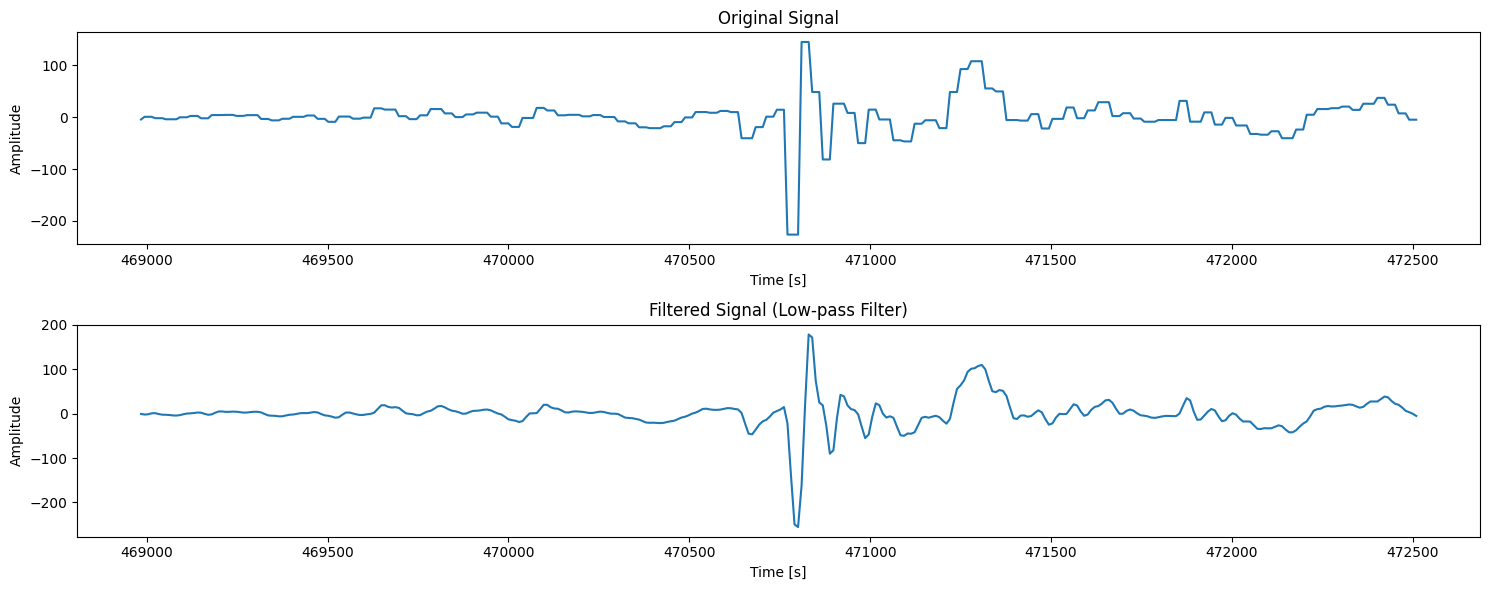

In [52]:
# Check the filter and find appropriate parameters
from scipy.signal import lfilter, butter

data = folder[0].data_filtered
old_data = folder[0].data["Thigh_R_Gyroscope_Y"]
new_data = None

# Sampling frequency
ts = data["Timestamp"].diff().median()  # Sampling time
fs = 1000/ts                            # Sampling frequency

# Filter design
N = 3               # Order of the filter 
cutoff = 25.0       # Cutoff frequency

# Apply filter
new_data = low_pass_filter(ts, old_data)

# Plot the original and filtered signals
plt.figure(figsize=(15, 6))
start = 0
end = 500

plt.subplot(2, 1, 1)
plt.plot(data["Timestamp"][start:end], old_data[start:end])
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(data["Timestamp"][start:end], new_data[start:end])
plt.title('Filtered Signal (Low-pass Filter)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [53]:
# Remove outliers and smooth curve using a low pass filter
for folder in folders:
    for file in folder:
        # Extract sampling time
        ts = file.data_filtered["Timestamp"].diff().median() # Median sampling time

        # Remove outliers
        for name, data in file.data_filtered.items():
            if name != 'Timestamp':
                data = low_pass_filter(ts, data)

### Apply the slinding window technique

In [ ]:
# Check if technique works
tw = 350    # window size
dt = 50     # time increment

test = folder[0].data_filtered
output = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
    output = generate_features(test, tw, dt)

display(output)

In [56]:
tw = 350        # window size
dt = 50         # window step

# Apply the moving average filter to the data and get all features
for folder in folders:
    for file in folder[:2]: # TODO REMEMBER TO SWITCH TO ALL FILES!! 
        # Apply the slinding window to the data
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
            file.data_processed = generate_features(file.data_filtered, tw, dt)

        # Drop first row where the gradient is 0
        file.data_processed = file.data_processed.iloc[1:]

In [58]:
# Check if technique works
dfi.export(file.data_processed, "assets/table_4.png", max_rows=10, max_cols=5)
file.data_processed.head()

,Thigh_R_Gyroscope_X_max,Thigh_R_Gyroscope_Y_max,Thigh_R_Gyroscope_Z_max,Thigh_R_Accelerometer_X_max,Thigh_R_Accelerometer_Y_max,Thigh_R_Accelerometer_Z_max,Thigh_R_Magnetometer_X_max,Thigh_R_Magnetometer_Y_max,Thigh_R_Magnetometer_Z_max,Shank_R_Gyroscope_X_max,...,Foot_L_Magnetometer_Z_zero_crossings,Pelvis_Gyroscope_X_zero_crossings,Pelvis_Gyroscope_Y_zero_crossings,Pelvis_Gyroscope_Z_zero_crossings,Pelvis_Accelerometer_X_zero_crossings,Pelvis_Accelerometer_Y_zero_crossings,Pelvis_Accelerometer_Z_zero_crossings,Pelvis_Magnetometer_X_zero_crossings,Pelvis_Magnetometer_Y_zero_crossings,Pelvis_Magnetometer_Z_zero_crossings
5,0.9035,2.4764,0.1565,-1.7917,9.2613,3.2007,0.3714,-0.6874,-0.0672,1.5100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.9035,2.4764,0.7851,-1.7917,9.2613,3.3519,0.3714,-0.6796,-0.0651,2.4683,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
15,0.9035,2.4764,1.3421,-1.7917,9.3377,3.3519,0.3924,-0.6796,-0.0651,2.4683,...,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
20,0.9035,2.4764,1.3421,-1.7917,9.3377,3.3519,0.3924,-0.6796,-0.0651,2.4683,...,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
25,0.9035,4.8863,1.3421,-1.7917,9.3377,3.3519,0.3924,-0.6796,-0.0651,2.4683,...,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [59]:
def get_one_hot_encoding(folders):
    names = []
    for folder in folders:
        names.append(folder[0].folder_name)
    return pd.get_dummies(names)

In [61]:
names_one_hot = get_one_hot_encoding(folders)
dfi.export(names_one_hot, "assets/table_5.png")
names_one_hot.head()

,LGW,Ramp_ascend,Ramp_descend,Sit_to_stand,Stand_to_sit
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1


In [ ]:
# Combine all five actions into one dataframe and set the target labels using one-hot encoding 
iterator = 1
all_df = []

for folder in folders:    
    # Create single dataframe for action
    df = pd.DataFrame()
    df = pd.concat([file.data_processed for file in folder[:2]])

    # Add target labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
        df["Action"] = iterator
        iterator = iterator + 1
    
    # Add dataframe to the list
    all_df.append(df)

# Combine all dataframes into one
df = pd.concat(all_df)

In [ ]:
all_df[3]

,Thigh_R_Gyroscope_X_max,Thigh_R_Gyroscope_Y_max,Thigh_R_Gyroscope_Z_max,Thigh_R_Accelerometer_X_max,Thigh_R_Accelerometer_Y_max,Thigh_R_Accelerometer_Z_max,Thigh_R_Magnetometer_X_max,Thigh_R_Magnetometer_Y_max,Thigh_R_Magnetometer_Z_max,Shank_R_Gyroscope_X_max,...,Pelvis_Gyroscope_X_zero_crossings,Pelvis_Gyroscope_Y_zero_crossings,Pelvis_Gyroscope_Z_zero_crossings,Pelvis_Accelerometer_X_zero_crossings,Pelvis_Accelerometer_Y_zero_crossings,Pelvis_Accelerometer_Z_zero_crossings,Pelvis_Magnetometer_X_zero_crossings,Pelvis_Magnetometer_Y_zero_crossings,Pelvis_Magnetometer_Z_zero_crossings,Action
5,0.0778,0.9504,-0.2482,9.1975,3.6862,1.9447,-0.7676,-0.5379,-0.1410,0.0031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10,0.4147,0.9504,-0.2482,9.1975,3.6862,2.0192,-0.7638,-0.5359,-0.1410,0.0246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
15,0.4147,0.9504,-0.2482,9.1975,3.6862,2.0192,-0.7638,-0.5359,-0.1410,0.0515,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4
20,0.4147,0.9504,-0.2482,9.1975,3.6862,2.0952,-0.7638,-0.5359,-0.1410,0.1236,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4
25,0.4147,0.9504,-0.2482,9.1975,3.6862,2.0952,-0.7638,-0.5359,-0.1410,0.1236,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,128.5291,297.8521,130.2913,20.9923,15.1420,9.2949,0.4838,-0.5165,0.1258,20.7544,...,23.0,24.0,28.0,22.0,0.0,4.0,1.0,0.0,1.0,4
340,128.5291,297.8521,130.2913,20.9923,15.1420,9.2949,0.4838,-0.5165,0.1258,20.7544,...,23.0,24.0,29.0,23.0,0.0,4.0,1.0,0.0,1.0,4
345,128.5291,297.8521,130.2913,20.9923,15.1420,9.2949,0.4838,-0.5165,0.1258,20.7544,...,25.0,25.0,29.0,26.0,0.0,4.0,1.0,0.0,1.0,4
350,128.5291,297.8521,130.2913,20.9923,15.1420,9.2949,0.4838,-0.5165,0.1258,20.7544,...,25.0,25.0,30.0,27.0,0.0,4.0,1.0,0.0,1.0,4


## Train models

Start by splitting the data into training and testing.

In [1]:
# Visualisation
import matplotlib.pyplot as plt
from tabulate import tabulate
import dataframe_image as dfi

# Machine learning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import warnings

# Helper functions
from helper.helper_train import *

In [2]:
# get csv data
df = pd.read_csv('combined_data.csv')

In [3]:
display(df)

,Thigh_R_Gyroscope_X_max,Thigh_R_Gyroscope_Y_max,Thigh_R_Gyroscope_Z_max,Thigh_R_Accelerometer_X_max,Thigh_R_Accelerometer_Y_max,Thigh_R_Accelerometer_Z_max,Thigh_R_Magnetometer_X_max,Thigh_R_Magnetometer_Y_max,Thigh_R_Magnetometer_Z_max,Shank_R_Gyroscope_X_max,...,Pelvis_Gyroscope_X_zero_crossings,Pelvis_Gyroscope_Y_zero_crossings,Pelvis_Gyroscope_Z_zero_crossings,Pelvis_Accelerometer_X_zero_crossings,Pelvis_Accelerometer_Y_zero_crossings,Pelvis_Accelerometer_Z_zero_crossings,Pelvis_Magnetometer_X_zero_crossings,Pelvis_Magnetometer_Y_zero_crossings,Pelvis_Magnetometer_Z_zero_crossings,Action
0,0.5345,1.2220,-0.6233,-2.0293,9.1850,3.2015,-0.2743,-0.6893,-0.2148,-0.5441,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.5345,1.2220,-0.0365,-2.0285,9.1850,3.2038,-0.2743,-0.6854,-0.2148,-0.5441,...,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,0.5345,1.7379,0.0727,-2.0285,9.1850,3.2038,-0.2743,-0.6854,-0.2148,-0.3715,...,2.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1
3,0.5345,1.7379,0.3939,-2.0285,9.1850,3.2038,-0.2743,-0.6796,-0.2104,-0.2588,...,2.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1
4,0.5345,2.1635,0.5982,-2.0285,9.1850,3.2038,-0.2705,-0.6796,-0.2104,-0.0447,...,2.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,58.4263,95.4544,1.8409,12.1205,10.5597,5.1537,0.3962,-0.4971,-0.0542,37.9600,...,13.0,13.0,18.0,46.0,0.0,2.0,1.0,0.0,12.0,5
1430,58.4263,95.4544,7.9702,12.1205,10.5597,5.1537,0.3962,-0.4893,-0.0542,37.9600,...,13.0,14.0,19.0,48.0,0.0,2.0,1.0,0.0,13.0,5
1431,58.4263,95.4544,9.8914,12.1205,10.5597,5.1537,0.3962,-0.4893,-0.0542,37.9600,...,13.0,14.0,19.0,52.0,0.0,2.0,1.0,0.0,13.0,5
1432,58.4263,95.4544,9.8914,12.1205,10.5597,5.1537,0.3962,-0.4893,-0.0542,37.9600,...,13.0,14.0,19.0,52.0,0.0,2.0,1.0,0.0,13.0,5


In [4]:
# Split data
X = df.iloc[:, :-1]     # Input features
y = df.iloc[:, -1:]     # Target labels

# Split data into training (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109)

In [5]:
print("The dimension of train is {}".format(X_train.shape))
print("The dimension of test is {}".format(X_test.shape))

The dimension of train is (1003, 441)
The dimension of test is (431, 441)


In [6]:
value_count = pd.DataFrame()
data_train = y_train['Action'].value_counts()
data_test = y_test['Action'].value_counts()

value_count = pd.concat([data_train, data_test], axis=1)
value_count.insert(0, "Action", ['LGW', ' Ramp_ascend', 'Ramp_descend', 'Sit_to_stand', 'Stand_to_sit'], True)
value_count = value_count.set_axis(['Action', 'Train Value Count', 'Test Value Count'], axis=1)
value_count

,Action,Train Value Count,Test Value Count
1,LGW,443,179
2,Ramp_ascend,198,85
3,Ramp_descend,159,82
4,Sit_to_stand,109,44
5,Stand_to_sit,94,41


In [7]:
dfi.export(value_count, "assets/table_6.png")

### ANN

Without any hyperparameter tuning or scalar, the accuracy is 21.06% (included a random seed to ensure consistency). With a scalar added, the accuracy is already 98.6%. It goes up to 100% with hyperparameter tuning.

C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy:  0.9930394431554525
Precision:  0.9931976780364652
Recall:  0.9930394431554525
Classification error:  0.00696055684454755
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       179
           2       0.98      1.00      0.99        85
           3       1.00      0.96      0.98        82
           4       0.98      1.00      0.99        44
           5       1.00      1.00      1.00        41

    accuracy                           0.99       431
   macro avg       0.99      0.99      0.99       431
weighted avg       0.99      0.99      0.99       431



C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


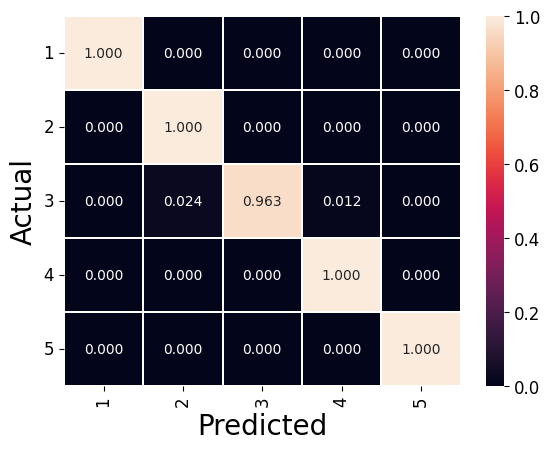

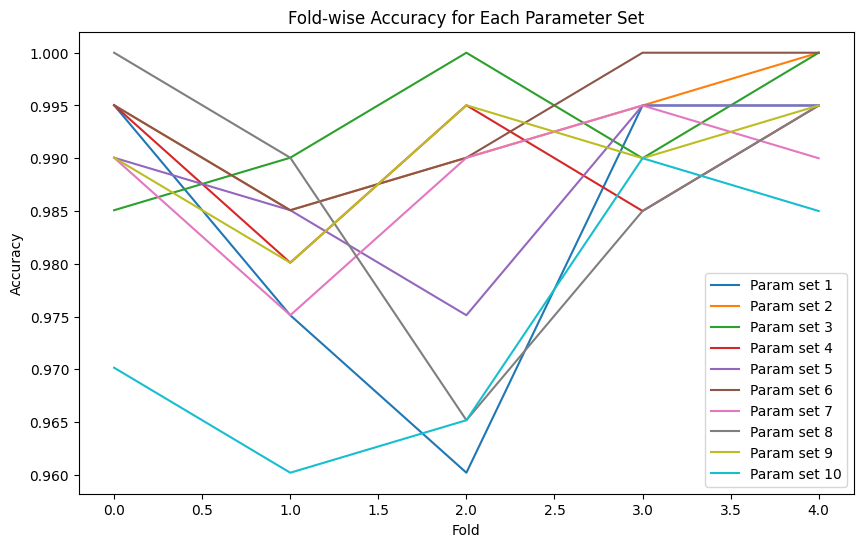

In [8]:
ann = ANN(X_train, X_test, y_train, y_test)
ann.run_pipeline()
ann.evaluate()

In [9]:
ann.best_params

{'solver': 'lbfgs',
 'max_iter': 300,
 'learning_rate_init': 0.001,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (50,),
 'early_stopping': True,
 'batch_size': 32,
 'alpha': 0.1,
 'activation': 'tanh'}

### SVM

Accuracy:  0.9791183294663574
Precision:  0.9794966205992132
Recall:  0.9791183294663574
Classification error:  0.02088167053364265
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       179
           2       0.96      0.96      0.96        85
           3       1.00      0.95      0.97        82
           4       1.00      1.00      1.00        44
           5       1.00      0.98      0.99        41

    accuracy                           0.98       431
   macro avg       0.99      0.98      0.98       431
weighted avg       0.98      0.98      0.98       431



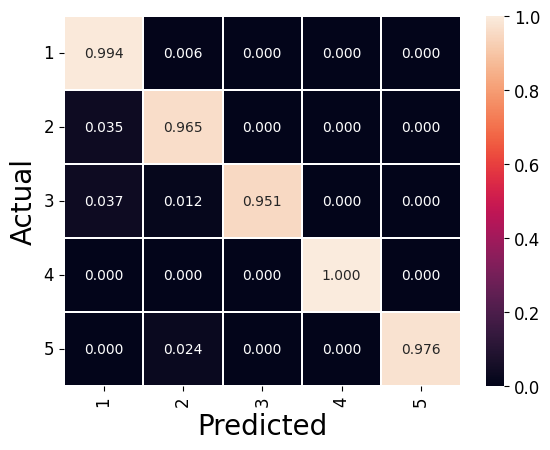

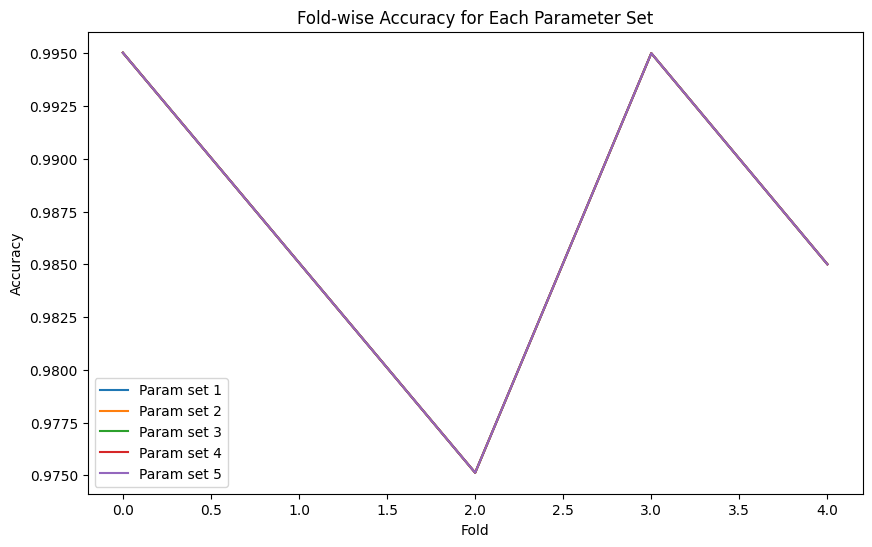

In [10]:
svm = SVM(X_train, X_test, y_train, y_test)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    svm.run_pipeline()
svm.evaluate()

In [11]:
svm.best_params

{'kernel': 'linear', 'C': 0.1}

### CNN

In [12]:
# TODO

### Comparison

Find the 15 most relevant weights for both ANN and SVG. From the figures below, it can be seen how th emost important features in the dataset are related to the gyroscope value. This makes sense as our joints have a more rotational based motion rather than translational.

Text(0.5, 0, 'Permutation Importance')

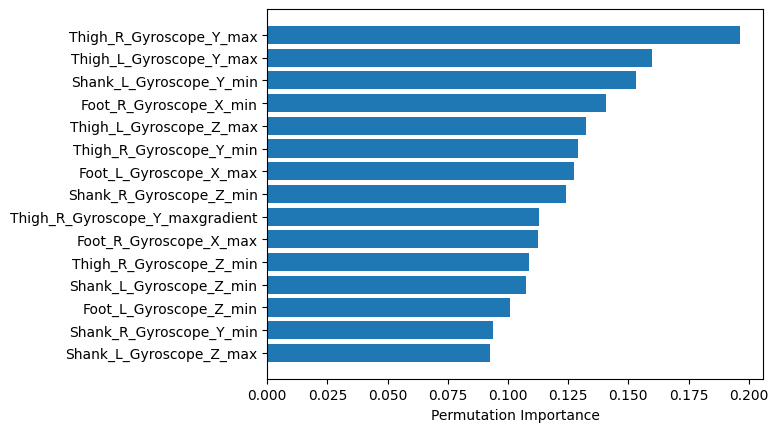

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ann_features, ann_scores = ann.get_most_relevant_features(X_train.columns,
                                                                X_train.values,
                                                                y_train.values)

# Plot
plt.barh(ann_features, ann_scores)
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

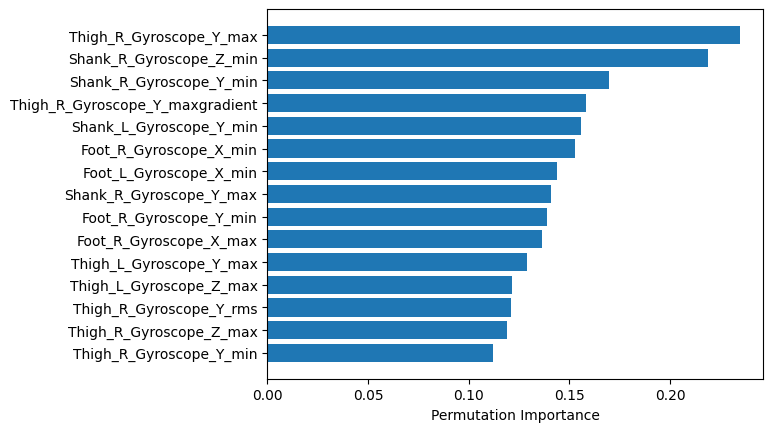

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    svm_features, svm_scores = svm.get_most_relevant_features(X_train.columns,
                                                                X_train.values,
                                                                y_train.values)

# Plot 
plt.barh(svm_features, svm_scores)
plt.xlabel("Permutation Importance")


Find the most significant segment which contributes to the activities recognition based on the ANN prediction

In [15]:
# Separate data based on the segment
sensors = ["Foot_L", "Foot_R", "Thigh_L", "Thigh_R", "Shank_L", "Shank_L", "Pelvis"]
sensors_data = {}

# Get all columns that contain the sensor name
for sensor in sensors:
    columns = [col for col in df.columns if (sensor in col or "Action" in col)]
    sensors_data[sensor] = df[columns]

In [16]:
# Print first sensor data
first_entry = next(iter(sensors_data.values()))
first_entry.head()

,Foot_L_Gyroscope_X_max,Foot_L_Gyroscope_Y_max,Foot_L_Gyroscope_Z_max,Foot_L_Accelerometer_X_max,Foot_L_Accelerometer_Y_max,Foot_L_Accelerometer_Z_max,Foot_L_Magnetometer_X_max,Foot_L_Magnetometer_Y_max,Foot_L_Magnetometer_Z_max,Foot_L_Gyroscope_X_min,...,Foot_L_Gyroscope_X_zero_crossings,Foot_L_Gyroscope_Y_zero_crossings,Foot_L_Gyroscope_Z_zero_crossings,Foot_L_Accelerometer_X_zero_crossings,Foot_L_Accelerometer_Y_zero_crossings,Foot_L_Accelerometer_Z_zero_crossings,Foot_L_Magnetometer_X_zero_crossings,Foot_L_Magnetometer_Y_zero_crossings,Foot_L_Magnetometer_Z_zero_crossings,Action
0,0.1372,-0.1706,-0.3320,0.0820,5.8642,-7.8518,-0.058,1.3887,0.1315,0.1040,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1
1,0.6534,-0.0197,-0.2147,0.0820,5.9396,-7.8518,-0.054,1.3950,0.1315,0.1040,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1
2,0.6534,-0.0197,-0.2091,0.0820,5.9396,-7.7739,-0.050,1.3992,0.1315,0.0755,...,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1
3,0.6534,-0.0197,-0.2091,0.0844,5.9396,-7.6897,-0.050,1.3992,0.1315,0.0755,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,1
4,0.6534,0.1322,0.0991,0.0844,6.0166,-7.6897,-0.050,1.3992,0.1315,-0.3424,...,1.0,2.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,1


In [17]:
models = []

# Get the accuracy of the ANN on each separate data
for key, data in sensors_data.items():
    # Split data
    X = data.iloc[:, :-1]     # Input features
    y = data.iloc[:, -1:]     # Target labels

    # Split data into training (70%) and testing set (30%)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.7, random_state=42)

    # Create network and get accuracy
    sensor_ann = ANN(X_tr, X_te, y_tr, y_te)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sensor_ann.run_pipeline()
        print(f'{key} accuracy : {sensor_ann.get_accuracy()}')

    # Add model to the list
    models.append(ModelToCompare(key , sensor_ann.get_accuracy(), sensor_ann, X_tr, X_te, y_tr, y_te))

Foot_L accuracy : 0.9482071713147411
Foot_R accuracy : 0.9432270916334662
Thigh_L accuracy : 0.9760956175298805
Thigh_R accuracy : 0.9492031872509961
Shank_L accuracy : 0.9661354581673307
Pelvis accuracy : 0.9890438247011952


Accuracy:  0.9890438247011952
Precision:  0.9890666062719591
Recall:  0.9890438247011952
Classification error:  0.010956175298804771
              precision    recall  f1-score   support

           1       0.99      1.00      1.00       457
           2       0.99      0.99      0.99       188
           3       0.98      0.99      0.99       170
           4       0.99      1.00      0.99        97
           5       0.99      0.92      0.96        92

    accuracy                           0.99      1004
   macro avg       0.99      0.98      0.98      1004
weighted avg       0.99      0.99      0.99      1004



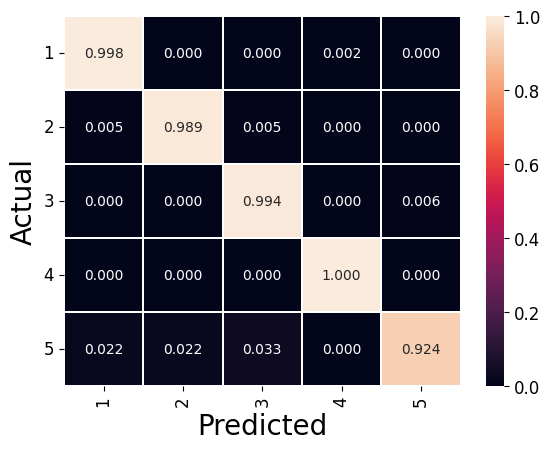

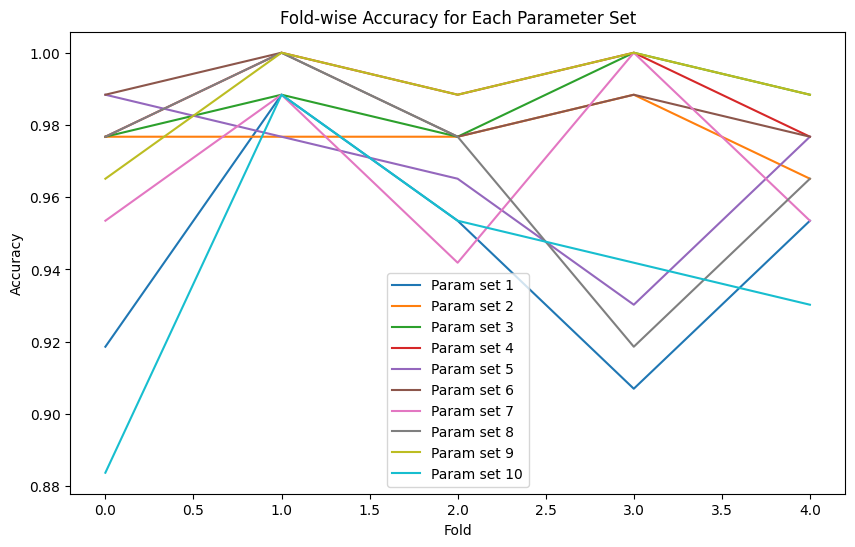

In [18]:
# Check highest accuacy
max_acc_model = max(models, key=lambda item: item.accuracy) 
max_acc_model.model.evaluate()

In [19]:
# Using only the most relevant feature, calculate the clasification error using ANN
print(f"Classification error of the ANN using {max_acc_model.sensor}: {max_acc_model.model.get_classification_error()}")

Classification error of the ANN using Pelvis: 0.010956175298804771


In [20]:
sensor = sensors_data[max_acc_model.sensor]

In [21]:
sensor.head()

,Pelvis_Gyroscope_X_max,Pelvis_Gyroscope_Y_max,Pelvis_Gyroscope_Z_max,Pelvis_Accelerometer_X_max,Pelvis_Accelerometer_Y_max,Pelvis_Accelerometer_Z_max,Pelvis_Magnetometer_X_max,Pelvis_Magnetometer_Y_max,Pelvis_Magnetometer_Z_max,Pelvis_Gyroscope_X_min,...,Pelvis_Gyroscope_X_zero_crossings,Pelvis_Gyroscope_Y_zero_crossings,Pelvis_Gyroscope_Z_zero_crossings,Pelvis_Accelerometer_X_zero_crossings,Pelvis_Accelerometer_Y_zero_crossings,Pelvis_Accelerometer_Z_zero_crossings,Pelvis_Magnetometer_X_zero_crossings,Pelvis_Magnetometer_Y_zero_crossings,Pelvis_Magnetometer_Z_zero_crossings,Action
0,0.2583,1.0746,0.0212,-0.0413,9.7934,-0.9448,-0.1688,-0.6264,-0.1636,-0.1519,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.2583,1.0746,0.1709,0.0391,9.7934,-0.9441,-0.1503,-0.6149,-0.1636,-0.5521,...,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,0.2583,1.0746,0.1709,0.0391,9.7934,-0.7886,-0.1503,-0.6111,-0.1590,-0.5521,...,2.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1
3,0.2583,1.0746,0.2347,0.0391,9.7934,-0.7886,-0.1503,-0.6111,-0.1590,-1.7013,...,2.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1
4,0.2583,1.0746,0.2347,0.0391,9.7934,-0.7886,-0.1503,-0.6111,-0.1590,-1.7013,...,2.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy of the SVM using Pelvis: 0.9890438247011952
Classification error of the SVM using Pelvis: 0.010956175298804771
Accuracy:  0.9890438247011952
Precision:  0.9892408871402394
Recall:  0.9890438247011952
Classification error:  0.010956175298804771
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       457
           2       0.99      0.99      0.99       188
           3       0.96      0.99      0.98       170
           4       1.00      1.00      1.00        97
           5       0.99      0.97      0.98        92

    accuracy                           0.99      1004
   macro avg       0.99      0.99      0.99      1004
weighted avg       0.99      0.99      0.99      1004



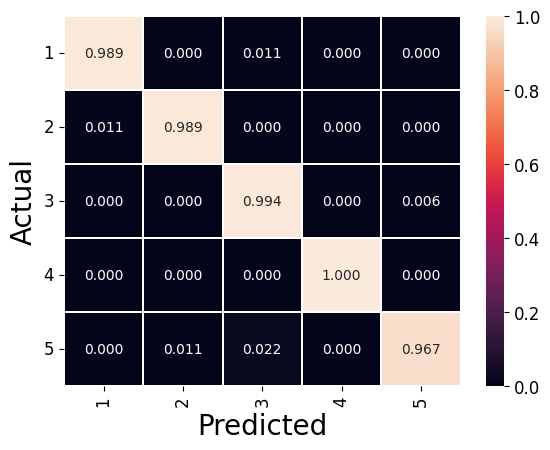

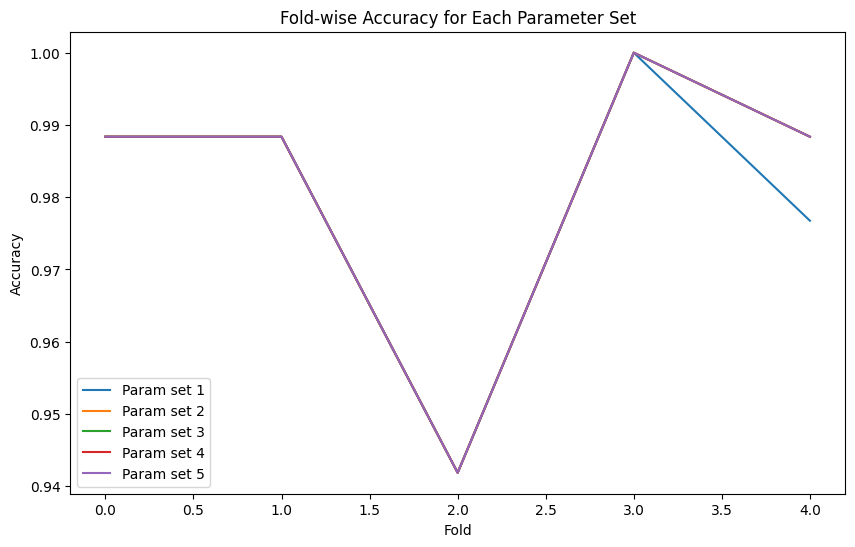

In [22]:
# Using only the most relevant feature, calculate the clasification error using SVM
sensor = sensors_data[max_acc_model.sensor]

# Split data
X = sensor.iloc[:, :-1]     # Input features
y = sensor.iloc[:, -1:]     # Target labels

# Split data into training (70%) and testing set (30%)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.7, random_state=42)

max_svm_model = SVM(X_tr, X_te, y_tr, y_te)
max_svm_model.run_pipeline()
print(f"Accuracy of the SVM using {max_acc_model.sensor}: {max_svm_model.get_accuracy()}")
print(f"Classification error of the SVM using {max_acc_model.sensor}: {max_svm_model.get_classification_error()}")
max_svm_model.evaluate()